# Analisi temporale - EA stock price

In [1]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install seaborn
%pip install tabulate
%pip install statsmodels --index-url=https://pypi.org/simple
%pip install sklearn
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
  Using cached jupyterlab_widgets-3.0.16-py3-none-any.whl.metadata (20 kB)
Using cached jupyterlab_widgets-3.0.16-py3-none-any.whl (914 kB)
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.15
    Uninstalling jupyterlab_widgets-3.0.15:
      Successfully uninstalled jupyterlab_widgets-3.0.15
  Rolling back uninstall of jupyterlab_widgets
  Moving to c:\users\lory8\appdata\local\packages\pythonsoftwarefoundation.python.3.12_qbz5n2kfra8p0\localcache\local-packages\python312\site-packages\jupyterlab_widgets-3.0.15.dist-info\
   from C:\Users\lory8\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\~upyterlab_widgets-3.0.15.dist-info
  Moving to c:\users\lory8\appdata\local\packages\pythonsoftwarefoundation.python.3.12_qbz5n2kfra8p0\localcache\local-packages\python312\site-packages\jupyterlab

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\lory8\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\share\\jupyter\\labextensions\\@jupyter-widgets\\jupyterlab-manager\\static\\packages_base_lib_index_js-webpack_sharing_consume_default_jquery_jquery.5dd13f8e980fa3c50bfe.js'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Caricamento dataset

In [2]:
from tabulate import tabulate
import kagglehub
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import itertools
import statsmodels.api as sm
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf

path = kagglehub.dataset_download("prathamjyotsingh/ea-stocks-latest")

# Caricamento del dataset delle temperature globali
df = pd.read_csv(os.path.join(path, 'EA_stock_price.csv'))

print("Forma del dataset:", df.shape)
print("\nPrime 5 righe:")
display(df.head())

print("\nInformazioni sul dataset:")
df.info()


Forma del dataset: (6258, 6)

Prime 5 righe:


,Date,Open Price,High Price,Low Price,Close Price,Volume
0,1999-11-01,80.63,84.53,80.63,82.31,2452700.0
1,1999-11-02,82.44,82.44,78.63,79.25,823500.0
2,1999-11-03,79.06,80.50,77.13,77.44,941800.0
3,1999-11-04,77.56,79.50,77.50,79.25,1264400.0
4,1999-11-05,80.38,82.00,79.38,81.88,2016200.0



Informazioni sul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6258 entries, 0 to 6257
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         6258 non-null   object 
 1   Open Price   6258 non-null   float64
 2   High Price   6258 non-null   float64
 3   Low Price    6258 non-null   float64
 4   Close Price  6258 non-null   float64
 5   Volume       6258 non-null   float64
dtypes: float64(5), object(1)
memory usage: 293.5+ KB


## ETL

In [3]:
# Copia, rimozione duplicati e valori nulli
dati = df.drop_duplicates().dropna().copy()

# Rinomina colonne
dati = dati.rename(columns={
    'Date': 'data',
    'Open Price': 'apertura',
    'High Price': 'massimo',
    'Low Price': 'minimo',
    'Close Price': 'chiusura',
    'Volume': 'volumi'
})

# Rimozione colonne inutilizzate per l’analisi
dati = dati.drop(columns=['apertura', 'massimo', 'minimo'])

# Conversione diretta della data
dati['data'] = pd.to_datetime(dati['data'])

# Calcolo settimana ISO (Anno + Numero settimana)
isocal = dati['data'].dt.isocalendar()
dati['anno'] = isocal.year
dati['settimana'] = isocal.week

# Creazione etichetta nel formato ISO: "YYYY-Www"
dati['etichetta_settimana'] = dati['anno'].astype(str) + '-W' + dati['settimana'].astype(str).str.zfill(2)

# Calcolo lunedì della settimana
dati['inizio_settimana'] = dati['data'] - pd.to_timedelta(dati['data'].dt.weekday, unit='d')

# Aggregazione settimanale
dati_settimanali = dati.groupby('inizio_settimana').agg({
    'chiusura': 'mean',
    'volumi': 'mean',
    'etichetta_settimana': 'first'
}).rename(columns={
    'chiusura': 'media_settimanale',
    'volumi': 'volume_settimanale'
})

# Reindicizzazione su tutte le settimane
idx = pd.date_range(dati_settimanali.index.min(), dati_settimanali.index.max(), freq='W-MON')
dati_settimanali = dati_settimanali.reindex(idx)
dati_settimanali.index.name = 'inizio_settimana'


# Interpolazione
dati_settimanali = dati_settimanali.interpolate()

# Numero progressivo settimana
dati_settimanali['numero_settimana'] = range(1, len(dati_settimanali)+1)


In [4]:
print("Informazioni generali sul dataset settimanale EA:")
dataset_info = pd.DataFrame({
    "Colonna": dati_settimanali.columns,
    "Valori Non-Nulli": dati_settimanali.notnull().sum().values,
    "Tipo Dati": dati_settimanali.dtypes.values
})

print(tabulate(dataset_info, headers="keys", tablefmt="grid"))

# Statistiche descrittive del dataset aggregato settimanalmente
print("\nStatistiche descrittive del dataset EA:")
statistiche_descrittive = dati_settimanali.describe().T  
display(statistiche_descrittive)

# Visualizzazione delle prime 5 righe del dataset settimanale
print("\nPrime 5 righe del dataset settimanale EA dopo ETL:")
display(dati_settimanali.head())

Informazioni generali sul dataset settimanale EA:
+----+---------------------+--------------------+-------------+
|    | Colonna             |   Valori Non-Nulli | Tipo Dati   |
+====+=====================+====================+=============+
|  0 | media_settimanale   |               1299 | float64     |
+----+---------------------+--------------------+-------------+
|  1 | volume_settimanale  |               1299 | float64     |
+----+---------------------+--------------------+-------------+
|  2 | etichetta_settimana |               1299 | object      |
+----+---------------------+--------------------+-------------+
|  3 | numero_settimana    |               1299 | int64       |
+----+---------------------+--------------------+-------------+

Statistiche descrittive del dataset EA:


,count,mean,std,min,25%,50%,75%,max
media_settimanale,1299.0,6.900743e+01,4.028598e+01,11.445,40.395,5.830250e+01,104.063,1.498310e+02
volume_settimanale,1299.0,4.022111e+06,2.410624e+06,486660.000,2442401.875,3.388940e+06,4881871.900,2.151155e+07
numero_settimana,1299.0,6.500000e+02,3.751333e+02,1.000,325.500,6.500000e+02,974.500,1.299000e+03



Prime 5 righe del dataset settimanale EA dopo ETL:


,media_settimanale,volume_settimanale,etichetta_settimana,numero_settimana
inizio_settimana,,,,
1999-11-01,80.026,1499720.0,1999-W44,1
1999-11-08,86.812,812100.0,1999-W45,2
1999-11-15,89.788,720220.0,1999-W46,3
1999-11-22,115.300,2710100.0,1999-W47,4
1999-11-29,107.920,1212660.0,1999-W48,5


## INIZIO SERIE TEMPORALI

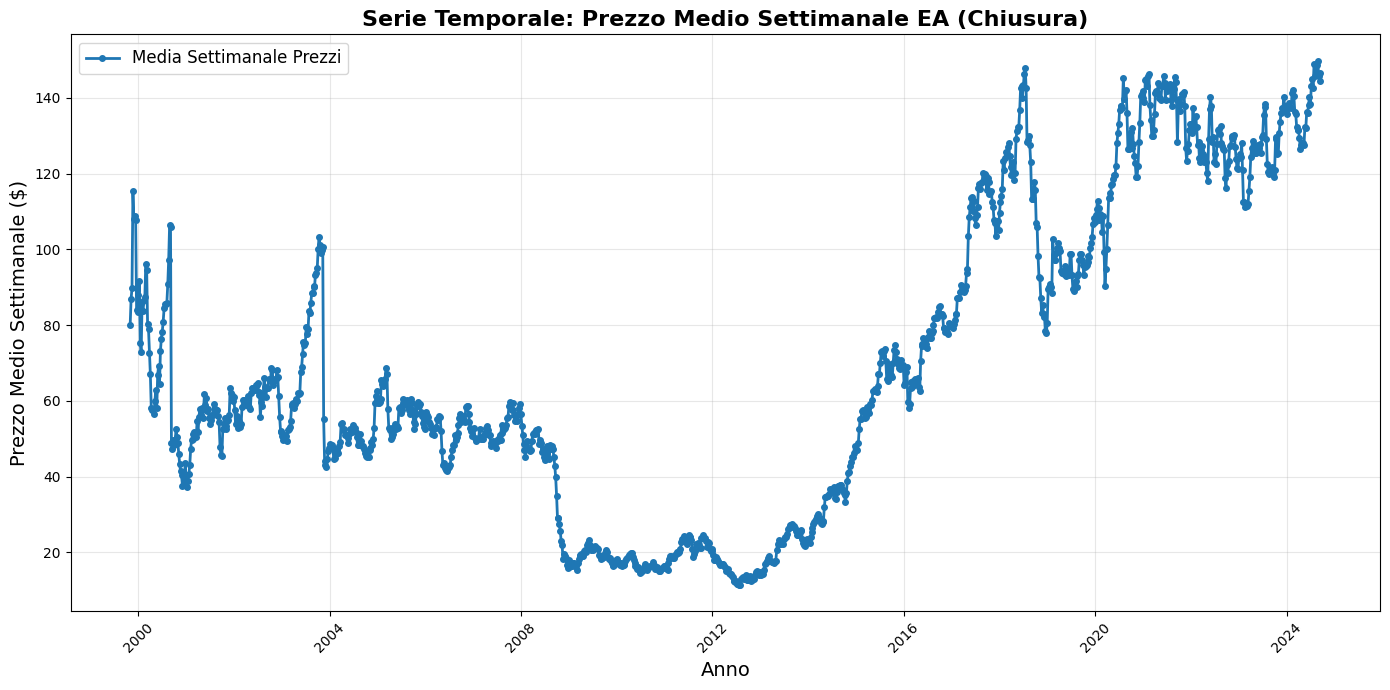

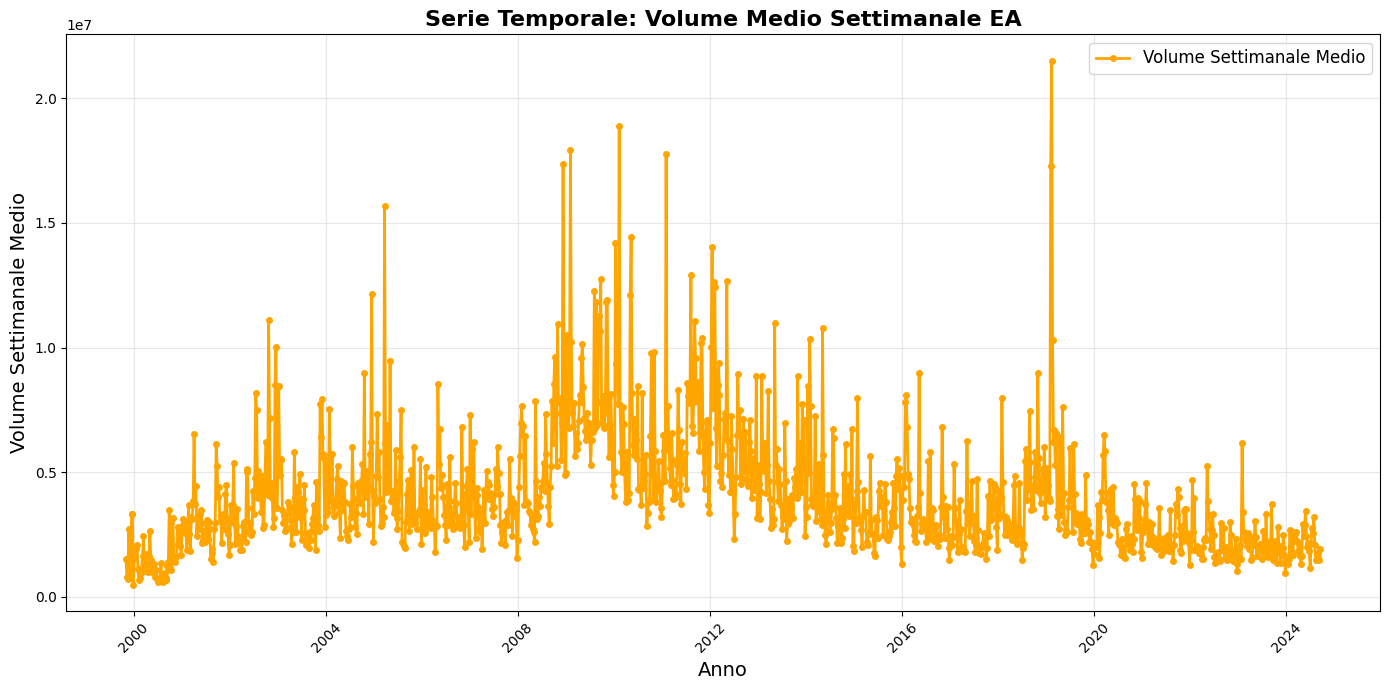

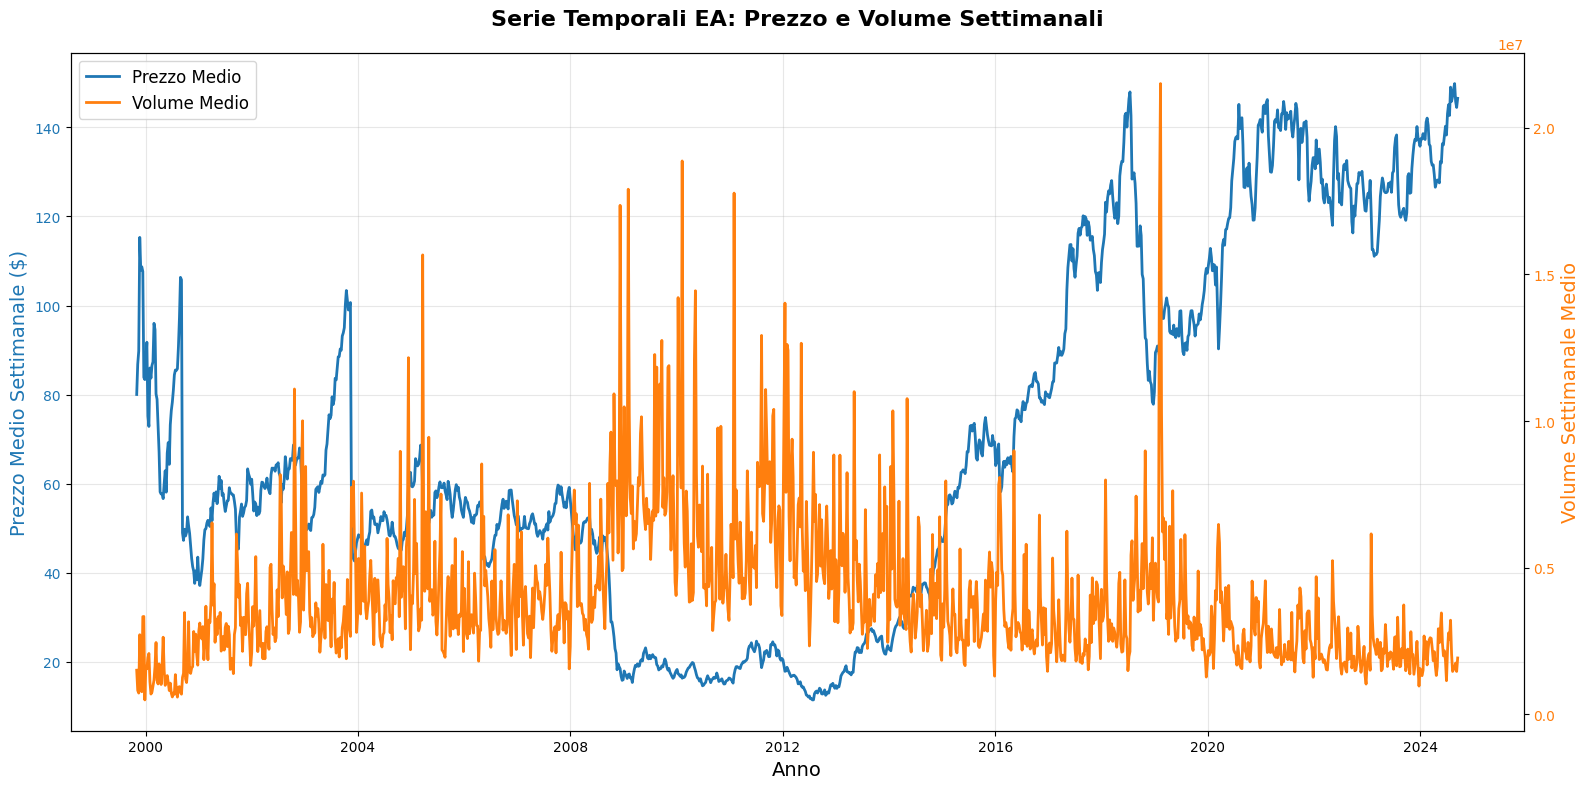

In [7]:
# Visualizzazione della serie temporale per i prezzi medi settimanali
plt.figure(figsize=(14, 7))
plt.plot(dati_settimanali.index, dati_settimanali['media_settimanale'], 
         label='Media Settimanale Prezzi', marker='o', linewidth=2, markersize=4)
plt.title('Serie Temporale: Prezzo Medio Settimanale EA (Chiusura)', fontsize=16, fontweight='bold')
plt.xlabel('Anno', fontsize=14)
plt.ylabel('Prezzo Medio Settimanale ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualizzazione della serie temporale per i volumi medi settimanali
plt.figure(figsize=(14, 7))
plt.plot(dati_settimanali.index, dati_settimanali['volume_settimanale'], 
         label='Volume Settimanale Medio', color='orange', marker='o', linewidth=2, markersize=4)
plt.title('Serie Temporale: Volume Medio Settimanale EA', fontsize=16, fontweight='bold')
plt.xlabel('Anno', fontsize=14)
plt.ylabel('Volume Settimanale Medio', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualizzazione combinata delle due serie (con assi diversi)
fig, ax1 = plt.subplots(figsize=(16, 8))

# Prima serie: prezzo medio
color1 = 'tab:blue'
ax1.set_xlabel('Anno', fontsize=14)
ax1.set_ylabel('Prezzo Medio Settimanale ($)', color=color1, fontsize=14)
line1 = ax1.plot(dati_settimanali.index, dati_settimanali['media_settimanale'], 
                 color=color1, linewidth=2, label='Prezzo Medio')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Seconda serie: volume (asse secondario)
ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel('Volume Settimanale Medio', color=color2, fontsize=14)
line2 = ax2.plot(dati_settimanali.index, dati_settimanali['volume_settimanale'], 
                 color=color2, linewidth=2, label='Volume Medio')
ax2.tick_params(axis='y', labelcolor=color2)

# Titolo e legenda
plt.title('Serie Temporali EA: Prezzo e Volume Settimanali', fontsize=16, fontweight='bold', pad=20)
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## DECOMPOSIZIONE SERIE TEMPORALE

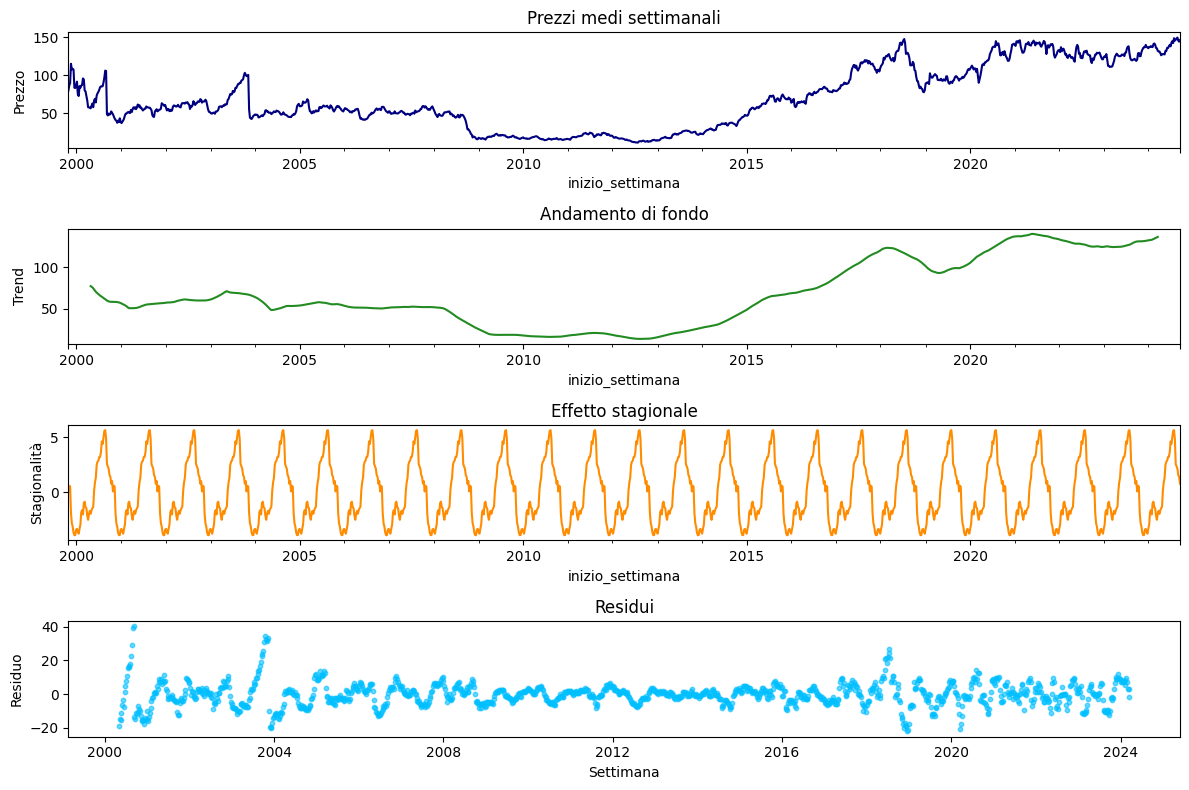

In [8]:
# Scomposizione della serie dei prezzi medi settimanali
result = seasonal_decompose(dati_settimanali['media_settimanale'], model='additive', period=52)

# Visualizzazione delle componenti principali
fig, axs = plt.subplots(4, 1, figsize=(12, 8))

# Serie originale
result.observed.plot(ax=axs[0], color='navy')
axs[0].set_title('Prezzi medi settimanali')
axs[0].set_ylabel('Prezzo')

# Componente trend
result.trend.plot(ax=axs[1], color='forestgreen')
axs[1].set_title('Andamento di fondo')
axs[1].set_ylabel('Trend')

# Componente stagionale
result.seasonal.plot(ax=axs[2], color='darkorange')
axs[2].set_title('Effetto stagionale')
axs[2].set_ylabel('Stagionalità')

# Residui (punti)
axs[3].scatter(result.resid.index, result.resid, color='deepskyblue', alpha=0.6, s=10)
axs[3].set_title('Residui')
axs[3].set_ylabel('Residuo')
axs[3].set_xlabel('Settimana')

plt.tight_layout()
plt.show()

## Verifica stazionarietà serie temporale

In [9]:
# Verifica della stazionarietà con Dickey-Fuller
stat_test = adfuller(dati_settimanali['media_settimanale'].dropna())

# Output dei risultati
print("Risultato Dickey-Fuller:")
print(f"Statistica: {stat_test[0]}")
print(f"P-value: {stat_test[1]}")
print("Soglie di riferimento:")
for livello, soglia in stat_test[4].items():
    print(f"  {livello}: {soglia}")

Risultato Dickey-Fuller:
Statistica: -1.140084341723486
P-value: 0.6988250155856683
Soglie di riferimento:
  1%: -3.435405786614854
  5%: -2.86377270896149
  10%: -2.567958709443111


## Differenziazione serie temporale

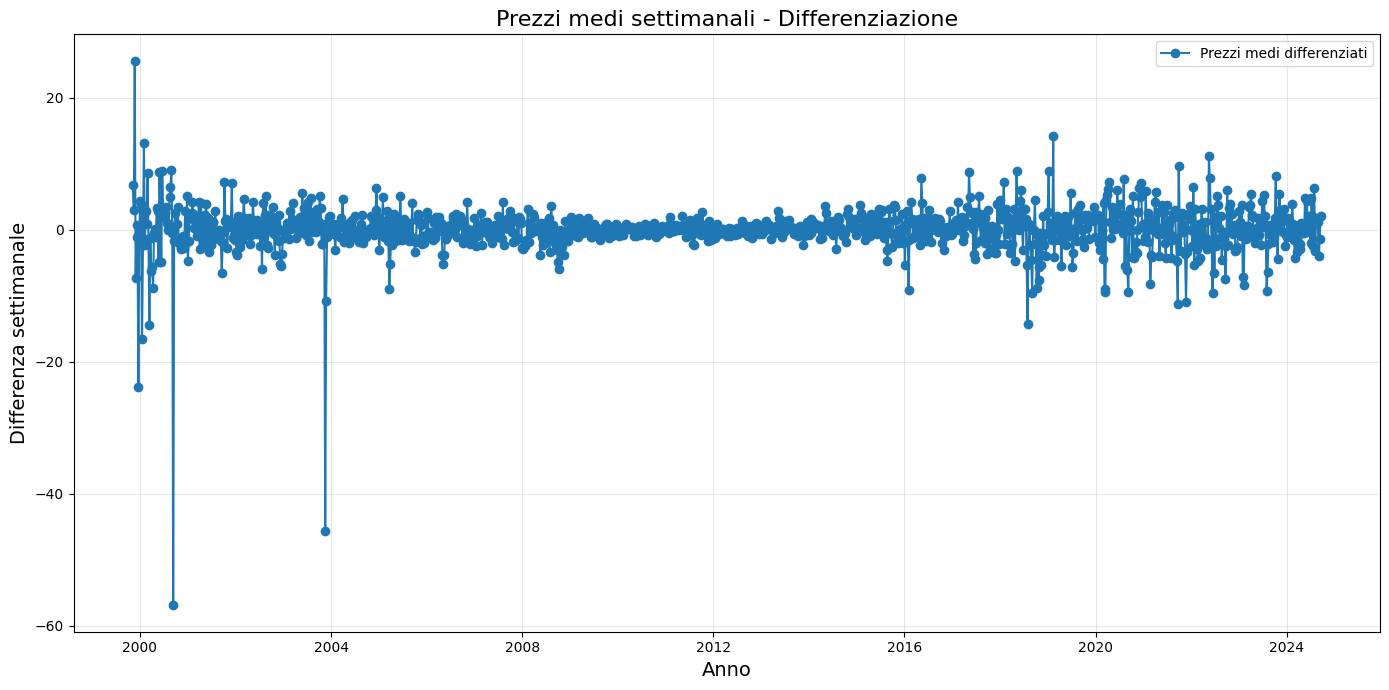

Test Dickey-Fuller sulla serie differenziata:
Statistica: -18.692775010094003
P-value: 2.0389011017654847e-30
Soglie di riferimento:
  1%: -3.4354136163971782
  5%: -2.8637761637845895
  10%: -2.5679605492954045


In [10]:
# Calcolo della serie differenziata per i prezzi medi settimanali
serie_diff = dati_settimanali['media_settimanale'].diff()

# Visualizzazione della serie differenziata
plt.figure(figsize=(14, 7))
plt.plot(dati_settimanali.index, serie_diff, label='Prezzi medi differenziati', marker='o')
plt.title('Prezzi medi settimanali - Differenziazione', fontsize=16)
plt.xlabel('Anno', fontsize=14)
plt.ylabel('Differenza settimanale', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Test Dickey-Fuller sulla serie differenziata
test_diff = adfuller(serie_diff.dropna())
print("Test Dickey-Fuller sulla serie differenziata:")
print(f"Statistica: {test_diff[0]}")
print(f"P-value: {test_diff[1]}")
print("Soglie di riferimento:")
for livello, soglia in test_diff[4].items():
    print(f"  {livello}: {soglia}")

**Stima manuale ACF e PACF**

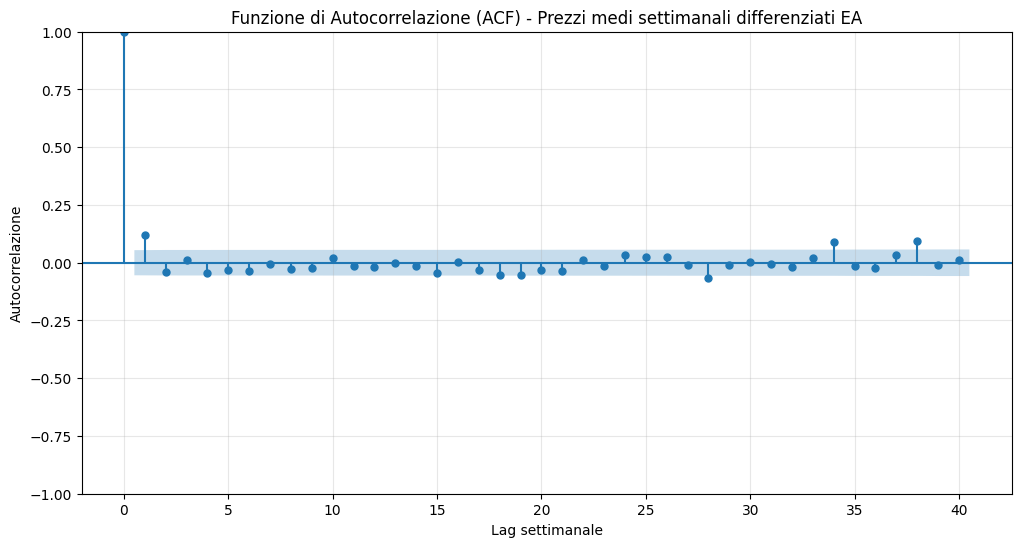

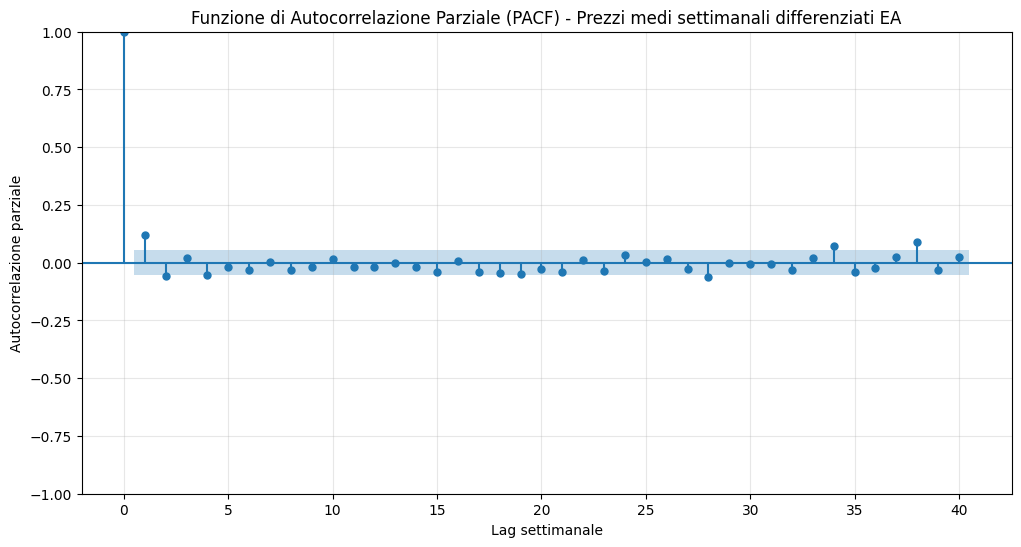

In [11]:
# Grafico ACF (Funzione di Autocorrelazione) sulla serie differenziata
plt.figure(figsize=(12, 6))
plot_acf(serie_diff.dropna(), lags=40, ax=plt.gca())
plt.title('Funzione di Autocorrelazione (ACF) - Prezzi medi settimanali differenziati EA')
plt.xlabel('Lag settimanale')
plt.ylabel('Autocorrelazione')
plt.grid(True, alpha=0.3)
plt.show()

# Grafico PACF (Funzione di Autocorrelazione Parziale) sulla serie differenziata 
plt.figure(figsize=(12, 6))
plot_pacf(serie_diff.dropna(), lags=40, ax=plt.gca(), method='ywm')
plt.title('Funzione di Autocorrelazione Parziale (PACF) - Prezzi medi settimanali differenziati EA')
plt.xlabel('Lag settimanale')
plt.ylabel('Autocorrelazione parziale')
plt.grid(True, alpha=0.3)
plt.show()

**Stima automatica di p e q**

Miglior modello ARIMA: ordine=(2, 1, 2), AIC=4809.436425672437
                               SARIMAX Results                                
Dep. Variable:      media_settimanale   No. Observations:                  909
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2399.718
Date:                Tue, 11 Nov 2025   AIC                           4809.436
Time:                        12:22:50   BIC                           4833.493
Sample:                    11-01-1999   HQIC                          4818.622
                         - 03-27-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4339      0.120      3.607      0.000       0.198       0.670
ar.L2          0.4449      0.131      3.387      0.001       0.187  

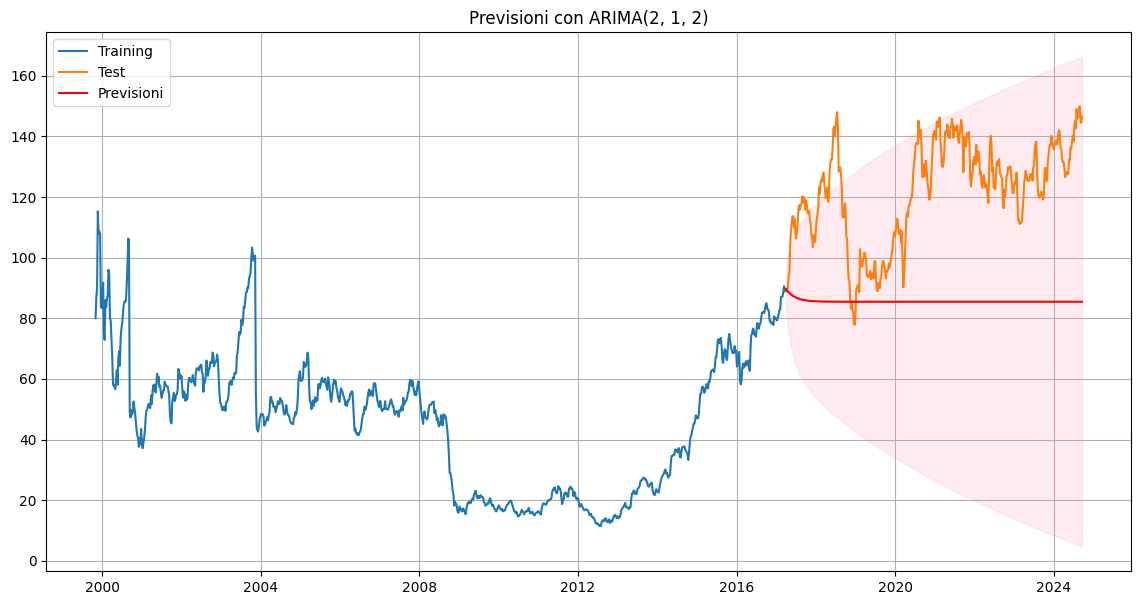

In [16]:
# Suddivisione del dataset in training e test
split_date = '31-03-2017'  # test-set 20%
train_data = dati_settimanali[:split_date]['media_settimanale']
test_data = dati_settimanali[split_date:]['media_settimanale']

# Definizione dei possibili parametri ARIMA
p = range(0, 3)  # Ordine autoregressivo
d = [1]           # Differenziazione (già applicata)
q = range(0, 3)  # Ordine media mobile

# Generazione di tutte le combinazioni (p, d, q)
pdq = list(itertools.product(p, d, q))

# Variabili per tracciare il miglior modello
best_aic = float('inf')
best_order = None
best_model = None

# Ricerca del miglior modello ARIMA tramite AIC
for param in pdq:
    try:
        modello = sm.tsa.ARIMA(train_data, order=param)
        risultati = modello.fit()
        if risultati.aic < best_aic:
            best_aic = risultati.aic
            best_order = param
            best_model = risultati
    except Exception as e:
        print(f"Errore con i parametri {param}: {e}")
        continue

# Stampa del miglior modello trovato
if best_order:
    print(f"Miglior modello ARIMA: ordine={best_order}, AIC={best_aic}")
else:
    print("Nessun modello ARIMA valido trovato.")

# Dettagli del miglior modello
if best_model:
    print(best_model.summary())

# Previsioni sul test set
if best_model:
    previsione = best_model.get_forecast(steps=len(test_data))
    previsione_ci = previsione.conf_int()

    plt.figure(figsize=(14, 7))
    plt.plot(train_data, label='Training')
    plt.plot(test_data, label='Test')
    plt.plot(previsione.predicted_mean, label='Previsioni', color='red')
    plt.fill_between(previsione_ci.index, 
                     previsione_ci.iloc[:, 0], 
                     previsione_ci.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'Previsioni con ARIMA{best_order}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
# Calcolo delle metriche di errore sulle previsioni ARIMA
if best_model:
    forecast_mean = previsione.predicted_mean
    mse = mean_squared_error(test_data, forecast_mean)
    mae = mean_absolute_error(test_data, forecast_mean)
    rmse = np.sqrt(mse)
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 36.3281828424491
Mean Squared Error (MSE): 1591.8900198992415
Root Mean Squared Error (RMSE): 39.89849646163677


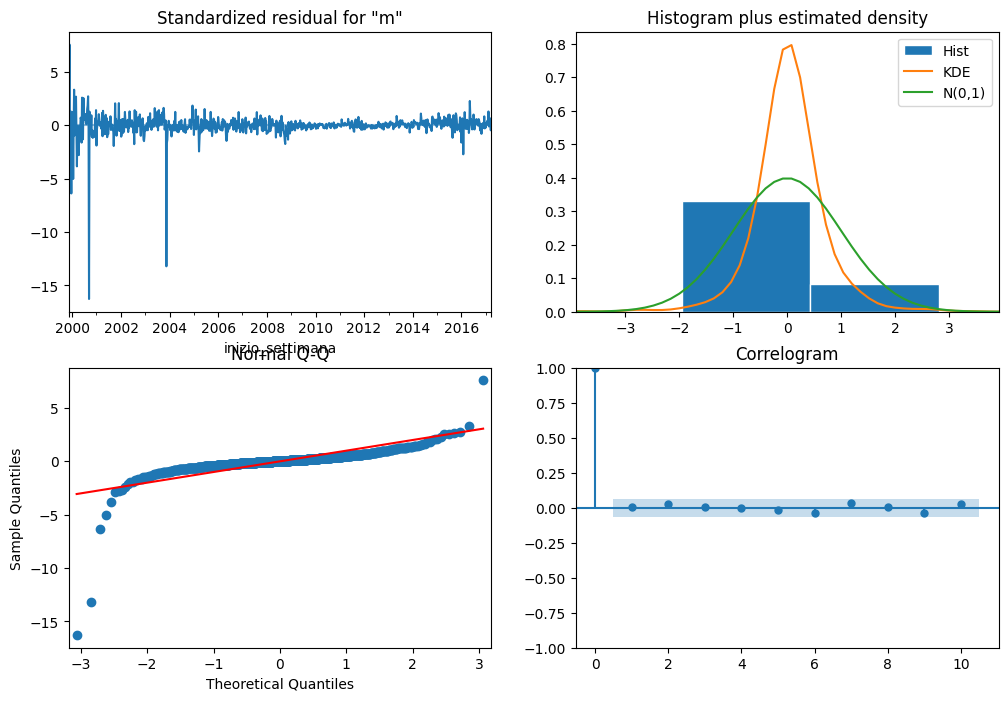

Test di Ljung-Box per i residui:
      lb_stat  lb_pvalue
10  27.548803   0.002131


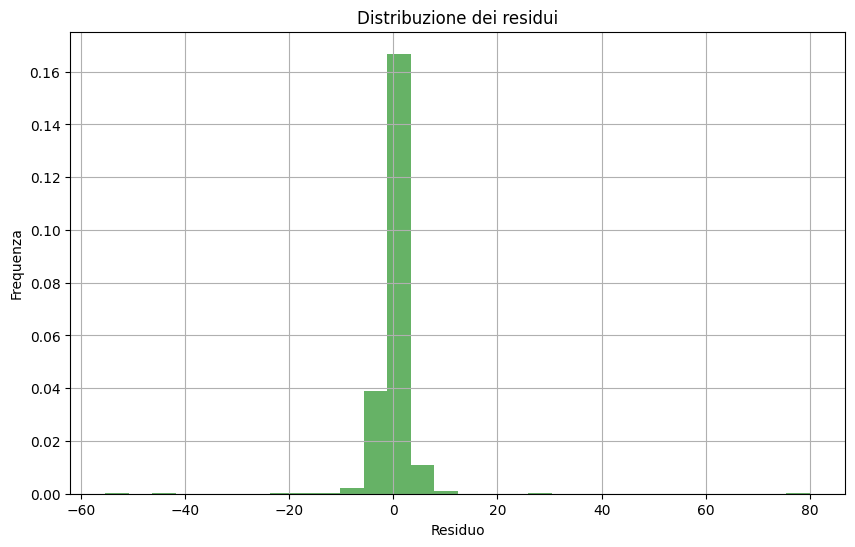

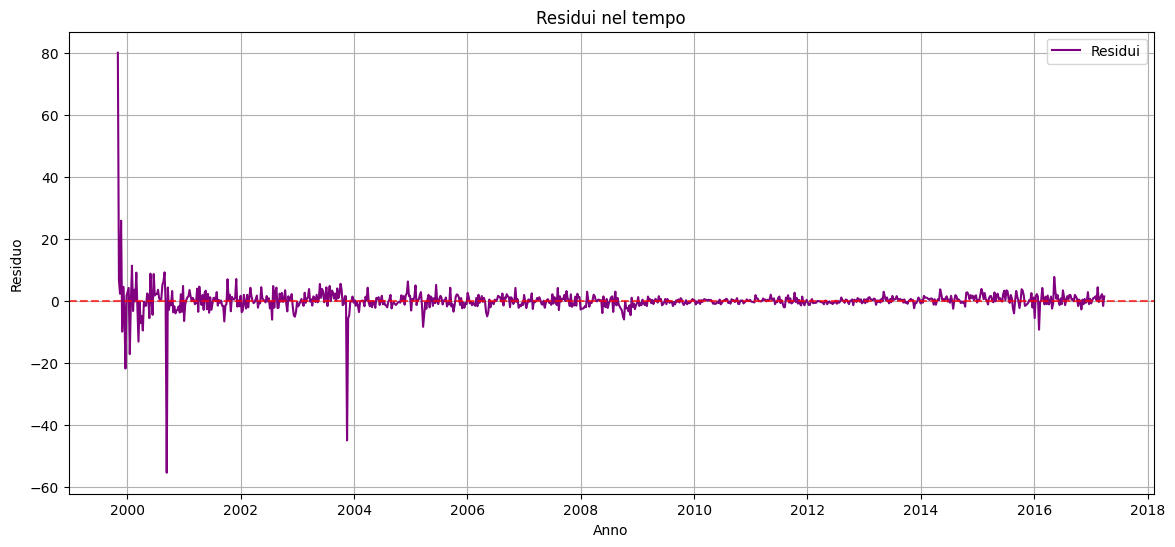

In [14]:
# Grafici diagnostici per il modello ARIMA
if best_model:
    best_model.plot_diagnostics(figsize=(12, 8))
    plt.show()

    # Analisi dei residui
    residuals = best_model.resid

    # Test di Ljung-Box per l'autocorrelazione nei residui
    ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Test di Ljung-Box per i residui:")
    print(ljung_box_results)

    # Grafico della distribuzione dei residui
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
    plt.title("Distribuzione dei residui")
    plt.xlabel("Residuo")
    plt.ylabel("Frequenza")
    plt.grid(True)
    plt.show()

    # Grafico dei residui nel tempo
    plt.figure(figsize=(14, 6))
    plt.plot(residuals, label='Residui', color='purple')
    plt.axhline(0, linestyle='--', color='red', alpha=0.7)
    plt.title("Residui nel tempo")
    plt.xlabel("Anno")
    plt.ylabel("Residuo")
    plt.legend()
    plt.grid(True)
    plt.show()

## Applicazione modello SARIMA 


In [ ]:
# Confronto tra modelli SARIMA (settimanale)
start_time = time.time()

# Definizione dei parametri per il modello SARIMA
p = range(0, 3)  # Parametri autoregressivi
d = [1]          # Differenziazione
q = range(0, 3)  # Parametri della media mobile
P = range(0, 2)  # Parametri stagionali autoregressivi
D = [1]          # Differenziazione stagionale
Q = range(0, 2)  # Parametri stagionali della media mobile
s = [52]         # Stagionalità settimanale (52 settimane per anno)

# Genera tutte le combinazioni di parametri SARIMA
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))
print(f"Numero totale di combinazioni da testare: {len(param_combinations)}")

# Variabili per memorizzare i risultati
results_summary = []

# Ciclo per valutare ogni combinazione di parametri
for idx, param in enumerate(param_combinations):
    try:
        print(f"[{idx+1}/{len(param_combinations)}] Testo SARIMA{param}...")
        # Definisci il modello SARIMA
        model = SARIMAX(train_data, order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], param[6]),
                        enforce_stationarity=False, enforce_invertibility=False)
        # Adatta il modello
        fitted_model = model.fit(disp=False)

        # Previsioni sui dati di test
        forecast = fitted_model.forecast(steps=len(test_data))

        # Calcola le metriche di accuratezza
        mae = mean_absolute_error(test_data, forecast)
        rmse = np.sqrt(mean_squared_error(test_data, forecast))
        mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

        # Salva i risultati
        results_summary.append({
            'Model': f"SARIMA{param}",
            'AIC': fitted_model.aic,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        })
    except Exception as e:
        print(f"Errore con i parametri {param}: {e}")
        continue

# Ordina i risultati per AIC
results_summary = sorted(results_summary, key=lambda x: x['AIC'])

# Stampa i risultati ordinati
print("Confronto tra Modelli SARIMA:")
for result in results_summary:
    print(f"Modello: {result['Model']}, AIC: {result['AIC']:.2f}, MAE: {result['MAE']:.2f}, RMSE: {result['RMSE']:.2f}, MAPE: {result['MAPE']:.2f}%")

# Mostra i primi 3 modelli migliori in base all'AIC
print("\nTop 3 modelli migliori in base all'AIC:")
for result in results_summary[:3]:
    print(f"Modello: {result['Model']}, AIC: {result['AIC']:.2f}, MAE: {result['MAE']:.2f}, RMSE: {result['RMSE']:.2f}, MAPE: {result['MAPE']:.2f}%")
print(f"Tempo totale impiegato: {round((time.time()-start_time)/60,2)} minuti")

Numero totale di combinazioni da testare: 36
[1/36] Testo SARIMA(0, 1, 0, 0, 1, 0, 52)...
[2/36] Testo SARIMA(0, 1, 0, 0, 1, 1, 52)...
[2/36] Testo SARIMA(0, 1, 0, 0, 1, 1, 52)...
[3/36] Testo SARIMA(0, 1, 0, 1, 1, 0, 52)...
[3/36] Testo SARIMA(0, 1, 0, 1, 1, 0, 52)...
[4/36] Testo SARIMA(0, 1, 0, 1, 1, 1, 52)...
[4/36] Testo SARIMA(0, 1, 0, 1, 1, 1, 52)...
[5/36] Testo SARIMA(0, 1, 1, 0, 1, 0, 52)...
[5/36] Testo SARIMA(0, 1, 1, 0, 1, 0, 52)...
[6/36] Testo SARIMA(0, 1, 1, 0, 1, 1, 52)...
[6/36] Testo SARIMA(0, 1, 1, 0, 1, 1, 52)...
[7/36] Testo SARIMA(0, 1, 1, 1, 1, 0, 52)...
[7/36] Testo SARIMA(0, 1, 1, 1, 1, 0, 52)...
[8/36] Testo SARIMA(0, 1, 1, 1, 1, 1, 52)...
[8/36] Testo SARIMA(0, 1, 1, 1, 1, 1, 52)...
[9/36] Testo SARIMA(0, 1, 2, 0, 1, 0, 52)...
[9/36] Testo SARIMA(0, 1, 2, 0, 1, 0, 52)...
[10/36] Testo SARIMA(0, 1, 2, 0, 1, 1, 52)...
[10/36] Testo SARIMA(0, 1, 2, 0, 1, 1, 52)...
[11/36] Testo SARIMA(0, 1, 2, 1, 1, 0, 52)...
[11/36] Testo SARIMA(0, 1, 2, 1, 1, 0, 52)...
[12/36

## APPLICAZIONE MIGLIOR MODELLO SARIMA

                                      SARIMAX Results                                       
Dep. Variable:                    media_settimanale   No. Observations:                  909
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 52)   Log Likelihood               -1885.702
Date:                              Thu, 25 Sep 2025   AIC                           3781.405
Time:                                      19:27:28   BIC                           3804.834
Sample:                                  11-01-1999   HQIC                          3790.405
                                       - 03-27-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1932      0.037      5.206      0.000       0.120       0.266
ma.L2          0.02

                                      SARIMAX Results                                       
Dep. Variable:                    media_settimanale   No. Observations:                  909
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 52)   Log Likelihood               -1885.702
Date:                              Thu, 25 Sep 2025   AIC                           3781.405
Time:                                      19:27:28   BIC                           3804.834
Sample:                                  11-01-1999   HQIC                          3790.405
                                       - 03-27-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1932      0.037      5.206      0.000       0.120       0.266
ma.L2          0.02

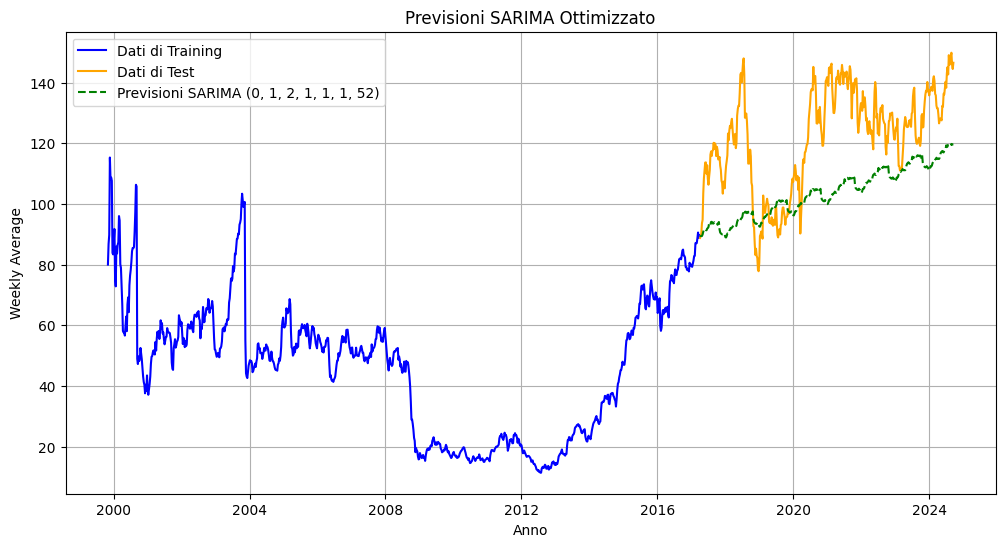

In [25]:
# Applicazione del miglior modello SARIMA trovato
best_params = (0, 1, 2, 1, 1, 1, 52)  # Parametri ottimali SARIMA
 
# Adattamento del modello SARIMA con i parametri ottimali
model = SARIMAX(
    train_data,
    order=(best_params[0], best_params[1], best_params[2]),
    seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]),
    enforce_stationarity=False,
    enforce_invertibility=False
 )
fitted_model = model.fit(disp=False)
 
# Sommario del modello
print(fitted_model.summary())
 
# Previsioni sui dati di test
forecast = fitted_model.forecast(steps=len(test_data))
forecast.index = test_data.index  # Riallinea l'indice delle previsioni
 
# Calcolo delle metriche di accuratezza
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
 
print(f"MAE del modello ottimizzato: {mae:.2f}")
print(f"RMSE del modello ottimizzato: {rmse:.2f}")
print(f"MAPE del modello ottimizzato: {mape:.2f}%")
 
# Grafico delle previsioni SARIMA ottimizzato
plt.figure(figsize=(12, 6))
plt.plot(train_data, label="Dati di Training", color="blue")
plt.plot(test_data, label="Dati di Test", color="orange")
plt.plot(forecast, label=f"Previsioni SARIMA {best_params}", linestyle="--", color="green")
plt.title("Previsioni SARIMA Ottimizzato")
plt.xlabel("Anno")
plt.ylabel("Weekly Average")
plt.legend()
plt.grid()
plt.show()

## GRAFICI DIAGNOSTICI SARIMA

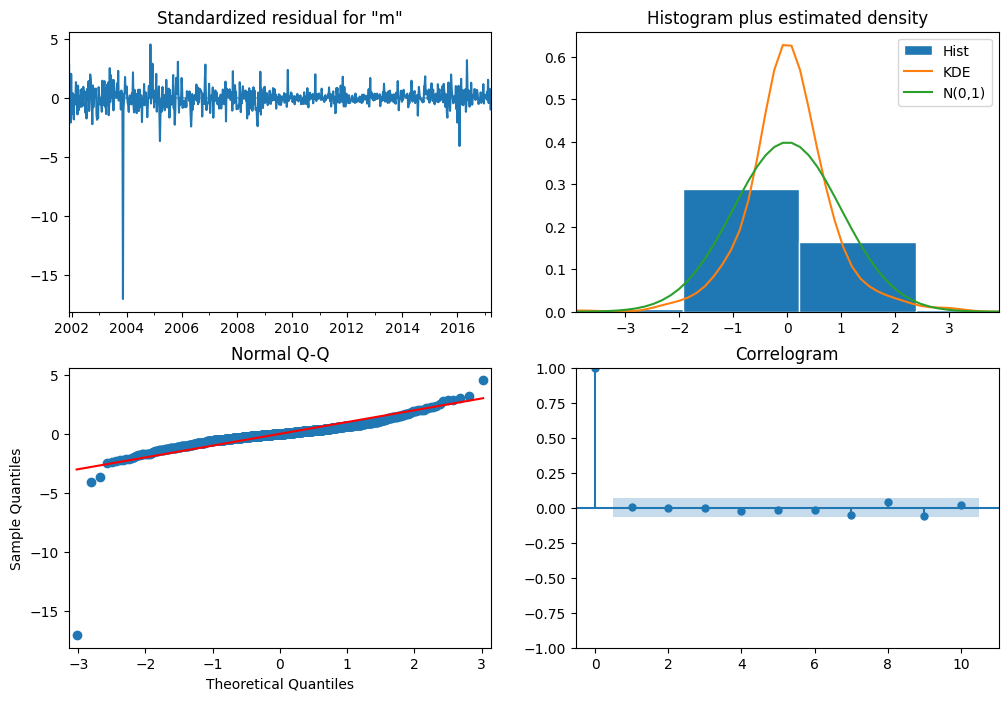

In [26]:
fitted_model.plot_diagnostics(figsize=(12, 8))
plt.show()

## OTTIMIZZAZIONE E APPLICAZIONE SARIMAX

**Le previsioni dovrebbero ora essere più accurate, includendo variabili esogene come weekly_volume.**

Numero totale di combinazioni da testare: 81
[1/81] Testo SARIMAX(0, 1, 0, 0, 1, 0, 52)...
SARIMAX(0, 1, 0, 0, 1, 0, 52) completato. AIC: 9839.09
[2/81] Testo SARIMAX(0, 1, 0, 0, 1, 1, 52)...
SARIMAX(0, 1, 0, 0, 1, 0, 52) completato. AIC: 9839.09
[2/81] Testo SARIMAX(0, 1, 0, 0, 1, 1, 52)...
SARIMAX(0, 1, 0, 0, 1, 1, 52) completato. AIC: 4805.15
[3/81] Testo SARIMAX(0, 1, 0, 0, 1, 2, 52)...
SARIMAX(0, 1, 0, 0, 1, 1, 52) completato. AIC: 4805.15
[3/81] Testo SARIMAX(0, 1, 0, 0, 1, 2, 52)...
SARIMAX(0, 1, 0, 0, 1, 2, 52) completato. AIC: 6309.17
[4/81] Testo SARIMAX(0, 1, 0, 1, 1, 0, 52)...
SARIMAX(0, 1, 0, 0, 1, 2, 52) completato. AIC: 6309.17
[4/81] Testo SARIMAX(0, 1, 0, 1, 1, 0, 52)...
SARIMAX(0, 1, 0, 1, 1, 0, 52) completato. AIC: 4917.46
[5/81] Testo SARIMAX(0, 1, 0, 1, 1, 1, 52)...
SARIMAX(0, 1, 0, 1, 1, 0, 52) completato. AIC: 4917.46
[5/81] Testo SARIMAX(0, 1, 0, 1, 1, 1, 52)...
SARIMAX(0, 1, 0, 1, 1, 1, 52) completato. AIC: 4884.28
[6/81] Testo SARIMAX(0, 1, 0, 1, 1, 2, 52)...


Numero totale di combinazioni da testare: 81
[1/81] Testo SARIMAX(0, 1, 0, 0, 1, 0, 52)...
SARIMAX(0, 1, 0, 0, 1, 0, 52) completato. AIC: 9839.09
[2/81] Testo SARIMAX(0, 1, 0, 0, 1, 1, 52)...
SARIMAX(0, 1, 0, 0, 1, 0, 52) completato. AIC: 9839.09
[2/81] Testo SARIMAX(0, 1, 0, 0, 1, 1, 52)...
SARIMAX(0, 1, 0, 0, 1, 1, 52) completato. AIC: 4805.15
[3/81] Testo SARIMAX(0, 1, 0, 0, 1, 2, 52)...
SARIMAX(0, 1, 0, 0, 1, 1, 52) completato. AIC: 4805.15
[3/81] Testo SARIMAX(0, 1, 0, 0, 1, 2, 52)...
SARIMAX(0, 1, 0, 0, 1, 2, 52) completato. AIC: 6309.17
[4/81] Testo SARIMAX(0, 1, 0, 1, 1, 0, 52)...
SARIMAX(0, 1, 0, 0, 1, 2, 52) completato. AIC: 6309.17
[4/81] Testo SARIMAX(0, 1, 0, 1, 1, 0, 52)...
SARIMAX(0, 1, 0, 1, 1, 0, 52) completato. AIC: 4917.46
[5/81] Testo SARIMAX(0, 1, 0, 1, 1, 1, 52)...
SARIMAX(0, 1, 0, 1, 1, 0, 52) completato. AIC: 4917.46
[5/81] Testo SARIMAX(0, 1, 0, 1, 1, 1, 52)...
SARIMAX(0, 1, 0, 1, 1, 1, 52) completato. AIC: 4884.28
[6/81] Testo SARIMAX(0, 1, 0, 1, 1, 2, 52)...


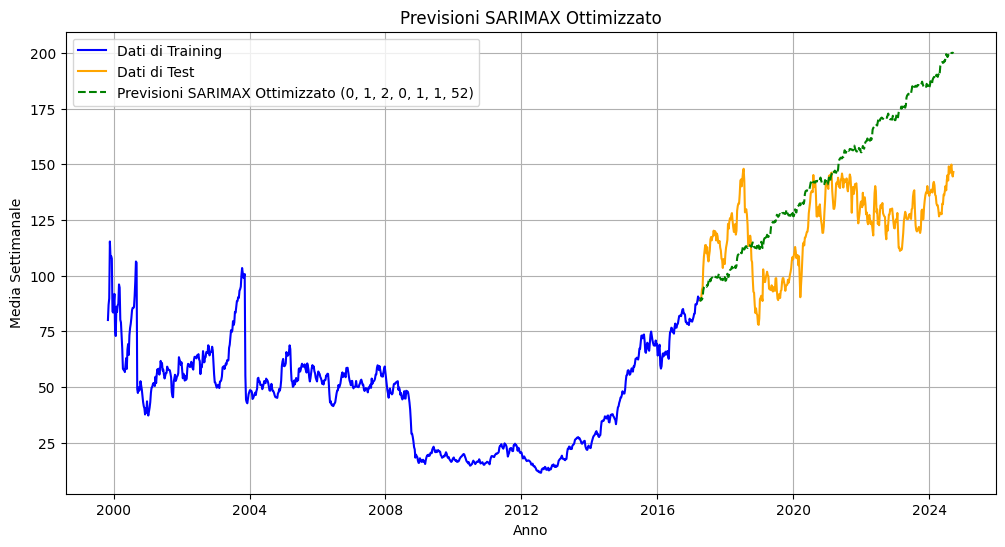

In [ ]:
# Ricerca del miglior modello SARIMAX con variabile esogena weekly_volume
start_time = time.time()
 
# Definizione dei range di parametri
p = range(0, 3)   # Ordine AR
d = [1]           # Differenziazione
q = range(0, 3)   # Ordine MA
P = range(0, 3)   # Ordine stagionale AR
D = [1]           # Differenziazione stagionale
Q = range(0, 3)   # Ordine stagionale MA
s = [52]          # Periodo stagionale (settimanale)
 
# Genera tutte le combinazioni possibili di parametri
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))
print(f"Numero totale di combinazioni da testare: {len(param_combinations)}")
 
# Variabili per memorizzare i risultati
best_aic = float('inf')
best_params = None
best_model = None
results_summary = []
 
# Usa i dati già definiti
train_data_weekly_volume = dati_settimanali.loc[:split_date, 'volume_settimanale']
test_data_weekly_volume = dati_settimanali.loc[split_date:, 'volume_settimanale']
 
# Ciclo su tutte le combinazioni di parametri
for idx, param in enumerate(param_combinations):
    try:
        print(f"[{idx+1}/{len(param_combinations)}] Testo SARIMAX{param}...")
        # Adatta il modello SARIMAX con volume settimanale come variabile esogena
        model = SARIMAX(
            train_data,
            exog=train_data_weekly_volume,
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], param[6])
        )
        results = model.fit(disp=False)
        
        # Confronta l'AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            best_model = results
        
        # Salva i risultati
        results_summary.append({
            'Params': param,
            'AIC': results.aic
        })
        print(f"SARIMAX{param} completato. AIC: {results.aic:.2f}")
    except Exception as e:
        print(f"Errore con i parametri {param}: {e}")
        continue
 
print(f"Tempo totale impiegato: {round((time.time()-start_time)/60,2)} minuti")
# Ordina i risultati per AIC
results_summary = sorted(results_summary, key=lambda x: x['AIC'])
 
# Stampa i migliori parametri
if best_params:
    print(f"Migliori parametri SARIMAX: {best_params}, AIC: {best_aic:.2f}")
else:
    print("Nessun modello valido trovato.")
 
# Dettagli del miglior modello
if best_model:
    print(best_model.summary())
 
# Previsioni con il modello ottimizzato
if best_model:
    forecast = best_model.forecast(steps=len(test_data), exog=test_data_weekly_volume)
    forecast.index = test_data.index  # Riallinea l'indice delle previsioni
    
    # Calcolo delle metriche di accuratezza
    mae = mean_absolute_error(test_data, forecast)
    rmse = np.sqrt(mean_squared_error(test_data, forecast))
    
    print(f"MAE del modello ottimizzato: {mae:.2f}")
    print(f"RMSE del modello ottimizzato: {rmse:.2f}")
    
    # Grafico delle previsioni
    plt.figure(figsize=(12, 6))
    plt.plot(train_data, label="Dati di Training", color="blue")
    plt.plot(test_data, label="Dati di Test", color="orange")
    plt.plot(forecast, label=f"Previsioni SARIMAX Ottimizzato {best_params}", linestyle="--", color="green")
    plt.title("Previsioni SARIMAX Ottimizzato")
    plt.xlabel("Anno")
    plt.ylabel("Media Settimanale")
    plt.legend()
    plt.grid()
    plt.show()

## GRAFICI DIAGNOSTICI SARIMAX

                                      SARIMAX Results                                       
Dep. Variable:                    media_settimanale   No. Observations:                  909
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 52)   Log Likelihood               -2114.770
Date:                              Fri, 26 Sep 2025   AIC                           4243.541
Time:                                      11:50:51   BIC                           4276.342
Sample:                                  11-01-1999   HQIC                          4256.141
                                       - 03-27-2017                                         
Covariance Type:                                opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
volume_settimanale -1.135e-07   9.48e-08     -1.197      0.231   -2.99e-07    7.24

                                      SARIMAX Results                                       
Dep. Variable:                    media_settimanale   No. Observations:                  909
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 52)   Log Likelihood               -2114.770
Date:                              Fri, 26 Sep 2025   AIC                           4243.541
Time:                                      11:50:51   BIC                           4276.342
Sample:                                  11-01-1999   HQIC                          4256.141
                                       - 03-27-2017                                         
Covariance Type:                                opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
volume_settimanale -1.135e-07   9.48e-08     -1.197      0.231   -2.99e-07    7.24

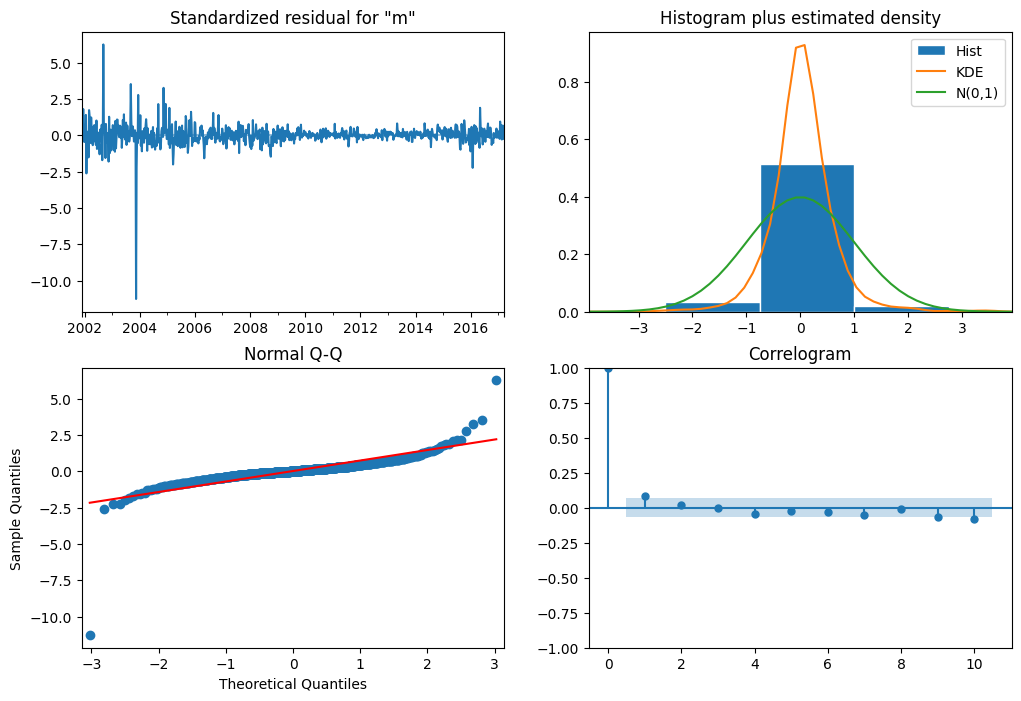

In [28]:
# Definizione e adattamento del modello SARIMAX con parametri forniti
sarimax_model = SARIMAX(
    train_data,
    exog=train_data_weekly_volume,
    order=(2, 1, 2),  # Parametri ARIMA (p, d, q)
    seasonal_order=(0, 1, 1, 52),  # Parametri stagionali (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False
 )
fitted_model = sarimax_model.fit(disp=False)
 
# Stampa del sommario del modello
print(fitted_model.summary())
 
# Grafici diagnostici del modello SARIMAX
fitted_model.plot_diagnostics(figsize=(12, 8))
plt.show()

**CALCOLO LE METRICHE DI SARIMAX**

In [ ]:
# Calcolo delle metriche di valutazione per il modello SARIMAX
 
# Valori reali del test set (media settimanale)
actual = test_data.values
 
# Prepara i dati esogeni per il test set (volume settimanale)
exog_test = test_data_weekly_volume.values.reshape(-1, 1)
 
# Ottieni il forecast dal modello SARIMAX ottimizzato
forecast = best_model.get_forecast(steps=len(test_data), exog=exog_test).predicted_mean.values
 
# Calcolo delle metriche
me = np.mean(forecast - actual)  # Mean Error (ME)
mae = np.mean(np.abs(forecast - actual))  # Mean Absolute Error (MAE)
mpe = np.mean((forecast - actual) / actual) * 100  # Mean Percentage Error (MPE)
mape = np.mean(np.abs((forecast - actual) / actual)) * 100  # Mean Absolute Percentage Error (MAPE)
rmse = np.sqrt(np.mean((forecast - actual) ** 2))  # Root Mean Squared Error (RMSE)
 
# Calcolo di ACF1 (Autocorrelazione dei residui al lag 1)
error = forecast - actual
acf1 = acf(error, nlags=1, fft=False)[1]  # Lag 1 Autocorrelation of Error (ACF1)
 
# Correlazione tra valori reali e previsione
corr = np.corrcoef(actual, forecast)[0, 1]  # Correlation between Actual and Forecast
 
# Min-Max Error
minmax = np.mean(np.abs(forecast - actual) / (np.max(actual) - np.min(actual)))  # Min-Max Error
 
# Creazione di una tabella con i risultati
metrics = {
    "Metric": ["ME", "MAE", "MPE", "MAPE", "RMSE", "ACF1", "Corr", "Min-Max Error"],
    "Value": [me, mae, mpe, mape, rmse, acf1, corr, minmax]
}
metrics_df = pd.DataFrame(metrics)
 
# Stampa della tabella
print("Metriche di valutazione del modello SARIMAX:")
print(metrics_df.to_string(index=False))

Metriche di valutazione del modello SARIMAX:
       Metric     Value
           ME 22.961675
          MAE 29.539860
          MPE 19.181501
         MAPE 24.540021
         RMSE 34.639124
         ACF1  0.987346
         Corr  0.558921
Min-Max Error  0.410299


## CONFRONTO METRICHE DEI MODELLI

In [ ]:
# Confronto tra modelli ARIMA, SARIMA e SARIMAX

# Modello ARIMA(2, 1, 2)
arima_model = ARIMA(train_data, order=(2, 1, 2)).fit()
arima_forecast = arima_model.forecast(steps=len(test_data))

# Metriche per ARIMA
arima_mse = mean_squared_error(test_data, arima_forecast)
arima_mae = mean_absolute_error(test_data, arima_forecast)
arima_aic = arima_model.aic

# Modello SARIMA(0, 1, 2, 1, 1, 1, 52)
sarima_model = SARIMAX(train_data, order=(0, 1, 2), seasonal_order=(1, 1, 1, 52)).fit(disp=False)
sarima_forecast = sarima_model.forecast(steps=len(test_data))

# Metriche per SARIMA
sarima_mse = mean_squared_error(test_data, sarima_forecast)
sarima_mae = mean_absolute_error(test_data, sarima_forecast)
sarima_aic = sarima_model.aic

# Modello SARIMAX(0, 1, 2, 0, 1, 1, 52)
sarimax_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(0, 1, 1, 52)).fit(disp=False)
sarimax_forecast = sarimax_model.forecast(steps=len(test_data))

# Metriche per SARIMAX
sarimax_mse = mean_squared_error(test_data, sarimax_forecast)
sarimax_mae = mean_absolute_error(test_data, sarimax_forecast)
sarimax_aic = sarimax_model.aic

# Creazione della tabella di confronto
metrics_comparison = pd.DataFrame({
    "Model": ["ARIMA(2,1,2)", "SARIMA(0,1,2)x(1,1,1,52)", "SARIMAX(0,1,2,0,1,1,52)"],
    "MSE": [arima_mse, sarima_mse, sarimax_mse],
    "MAE": [arima_mae, sarima_mae, sarimax_mae],
    "AIC": [arima_aic, sarima_aic, sarimax_aic]
})

# Visualizzazione della tabella
print("Confronto delle metriche di bontà dei modelli:")
print(metrics_comparison)

Confronto delle metriche di bontà dei modelli:
                      Model          MSE        MAE          AIC
0              ARIMA(2,1,2)  1591.890020  36.328183  4809.436426
1  SARIMA(0,1,2)x(1,1,1,52)   260.679840  13.819655  4689.604484
2   SARIMAX(0,1,2,0,1,1,52)   250.801726  13.318762  4686.583111
